# Up and Running With Tensorflow

In [1]:
import tensorflow as tf
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### Creating and running a graph inside a session

In [2]:
x = tf.Variable(3, name='x')
y = tf.Variable(4, name='y')
f = x*x*y + y + 2

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

In [4]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)
sess.close()

42


In [5]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()
print(result)

42


In [6]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    result = f.eval()
print(result)

42


In [7]:
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)
sess.close()

42


### Managing Graphs

In [8]:
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [9]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)
    
x2.graph is graph

True

In [10]:
x2.graph is tf.get_default_graph()

False

In [11]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())
    print(z.eval())

10
15


Above code actually computes w and x twice: once to evaluate y and once to evaluate z.  We can avoid this by running them in just one graph:

In [12]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y,z])
    print(y_val)
    print(z_val)

10
15


In [13]:
tf.reset_default_graph()

## Linear Regression

### Using the Normal Equation

In [14]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m,1)), housing.data]

In [15]:
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1,1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT,X)), XT), y)

In [19]:
with tf.Session() as sess:
    %time theta_value = theta.eval()

CPU times: user 11.3 ms, sys: 5.05 ms, total: 16.4 ms
Wall time: 15.9 ms


In [20]:
theta_value

array([[-3.7171074e+01],
       [ 4.3633682e-01],
       [ 9.3871783e-03],
       [-1.0717344e-01],
       [ 6.4540231e-01],
       [-4.1238391e-06],
       [-3.7809242e-03],
       [-4.2373490e-01],
       [-4.3720812e-01]], dtype=float32)

How does this compare with Scikit-Learn?

In [22]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
%time lin_reg.fit(housing.data, housing.target.reshape(-1,1))

print(np.r_[lin_reg.intercept_.reshape(-1,1), lin_reg.coef_.T])

CPU times: user 5.31 ms, sys: 1.68 ms, total: 6.99 ms
Wall time: 4.83 ms
[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


Same results, but Scikit-Learn apparently has a more optimized solver for the Normal Equation compared to computing it directly with tensorflow.

### Using Batch Gradient Descent

first need to scale the feature vectors such that the gradient magnitude is similar for all features

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m,1)), scaled_housing_data]

In [28]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1,1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n+1,1], -1, 1,), name="theta") #init model params to random values [-1,1]
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 ==0:
            print("Epoch", epoch, "MSE = ", mse.eval())
        sess.run(training_op)
        
    best_theta = theta.eval()
    
print("Best theta:")
print(best_theta)

Epoch 0 MSE =  10.876492
Epoch 100 MSE =  0.76645774
Epoch 200 MSE =  0.5931372
Epoch 300 MSE =  0.5729442
Epoch 400 MSE =  0.560546
Epoch 500 MSE =  0.55148345
Epoch 600 MSE =  0.54477835
Epoch 700 MSE =  0.53979796
Epoch 800 MSE =  0.5360853
Epoch 900 MSE =  0.53330714
Best theta:
[[ 2.0685523 ]
 [ 0.8563387 ]
 [ 0.1479282 ]
 [-0.27080688]
 [ 0.29018322]
 [ 0.00576369]
 [-0.04236399]
 [-0.6621006 ]
 [-0.6336789 ]]


We can also have Tensorflow calculate the gradients for us using autodiff:

In [29]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1,1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n+1,1], -1, 1,), name="theta") #init model params to random values [-1,1]
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = tf.gradients(mse, [theta])[0] #<---- let Tensorflow compute gradients
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 ==0:
            print("Epoch", epoch, "MSE = ", mse.eval())
        sess.run(training_op)
        
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE =  6.393575
Epoch 100 MSE =  0.6487504
Epoch 200 MSE =  0.5621233
Epoch 300 MSE =  0.55094266
Epoch 400 MSE =  0.5436701
Epoch 500 MSE =  0.53841144
Epoch 600 MSE =  0.534596
Epoch 700 MSE =  0.53182536
Epoch 800 MSE =  0.52981144
Epoch 900 MSE =  0.52834576
Best theta:
[[ 2.0685525e+00]
 [ 7.7697206e-01]
 [ 1.2889652e-01]
 [-1.2862097e-01]
 [ 1.7602295e-01]
 [-1.2908361e-04]
 [-3.9061900e-02]
 [-8.7537050e-01]
 [-8.3808714e-01]]


We can also use Tensorflow's optimizers, namely it's GradientDescentOptimizer

In [30]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1,1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n+1,1], -1, 1,), name="theta") #init model params to random values [-1,1]
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = tf.gradients(mse, [theta])[0] #<---- let Tensorflow compute gradients
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) #<---- built in optimizer
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 ==0:
            print("Epoch", epoch, "MSE = ", mse.eval())
        sess.run(training_op)
        
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE =  5.096866
Epoch 100 MSE =  0.65144324
Epoch 200 MSE =  0.5565618
Epoch 300 MSE =  0.54676133
Epoch 400 MSE =  0.5412652
Epoch 500 MSE =  0.537241
Epoch 600 MSE =  0.53422594
Epoch 700 MSE =  0.5319538
Epoch 800 MSE =  0.5302335
Epoch 900 MSE =  0.52892476
Best theta:
[[ 2.0685525 ]
 [ 0.7546378 ]
 [ 0.1201086 ]
 [-0.09502736]
 [ 0.1520272 ]
 [-0.00303659]
 [-0.03784217]
 [-0.9603986 ]
 [-0.9209319 ]]


Or we can use Tensorflow's MomentumOptimizer which converges faster:

In [31]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1,1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n+1,1], -1, 1,), name="theta") #init model params to random values [-1,1]
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = tf.gradients(mse, [theta])[0] #<---- let Tensorflow compute gradients
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9) #<---- built in optimizer
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 ==0:
            print("Epoch", epoch, "MSE = ", mse.eval())
        sess.run(training_op)
        
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE =  13.152174
Epoch 100 MSE =  0.5378876
Epoch 200 MSE =  0.524679
Epoch 300 MSE =  0.52434355
Epoch 400 MSE =  0.5243235
Epoch 500 MSE =  0.5243213
Epoch 600 MSE =  0.524321
Epoch 700 MSE =  0.524321
Epoch 800 MSE =  0.52432096
Epoch 900 MSE =  0.52432096
Best theta:
[[ 2.0685582 ]
 [ 0.8296237 ]
 [ 0.11875249]
 [-0.26553538]
 [ 0.30570337]
 [-0.00450276]
 [-0.03932643]
 [-0.8998756 ]
 [-0.87053144]]


### Using Mini-Batch Gradient Descent

In [35]:
n_epochs = 100
learning_rate = 0.01

tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None,1), name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [36]:
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m,size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1,1)[indices]
    return X_batch, y_batch


In [38]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
            
    best_theta = theta.eval()

In [39]:
best_theta

array([[ 2.0544672 ],
       [ 0.8297011 ],
       [ 0.10713524],
       [-0.3107482 ],
       [ 0.2456451 ],
       [-0.00222412],
       [-0.01061389],
       [-0.89121586],
       [-0.87524796]], dtype=float32)

## Saving and restoring a model

In [51]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1,1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n+1,1], -1, 1,), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = tf.gradients(mse, [theta])[0]
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver() #<-----

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 ==0:
            print("Epoch", epoch, "MSE = ", mse.eval())
            save_path = saver.save(sess, os.getcwd() + "/tmp/my_model.ckpt") # Save at checkpoints
        sess.run(training_op)
        
    best_theta = theta.eval()
    save_path = saver.save(sess, os.getcwd() + "/tmp/my_model_final.ckpt") # Save final model

print("Best theta:")
print(best_theta)

Epoch 0 MSE =  9.010693
Epoch 100 MSE =  0.7564409
Epoch 200 MSE =  0.6075356
Epoch 300 MSE =  0.58307356
Epoch 400 MSE =  0.5671018
Epoch 500 MSE =  0.5555586
Epoch 600 MSE =  0.5471715
Epoch 700 MSE =  0.54106873
Epoch 800 MSE =  0.5366224
Epoch 900 MSE =  0.5333784
Best theta:
[[ 2.0685525 ]
 [ 0.8238559 ]
 [ 0.14697392]
 [-0.19983095]
 [ 0.22726904]
 [ 0.00583903]
 [-0.04159085]
 [-0.6995705 ]
 [-0.6669037 ]]


In [53]:
with tf.Session() as sess:
    saver.restore(sess, os.getcwd() + "/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval()

np.allclose(best_theta, best_theta_restored)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/dhensle/Documents/dabbles-in-ML/oreilly/tmp/my_model_final.ckpt


True

The saver also saves the graph structure in a .meta file which can also be restored:

In [56]:
tf.reset_default_graph()

saver = tf.train.import_meta_graph(os.getcwd() + "/tmp/my_model_final.ckpt.meta")
theta = tf.get_default_graph().get_tensor_by_name("theta:0")

with tf.Session() as sess:
    saver.restore(sess, os.getcwd() + "/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval()

INFO:tensorflow:Restoring parameters from /Users/dhensle/Documents/dabbles-in-ML/oreilly/tmp/my_model_final.ckpt


In [57]:
np.allclose(best_theta, best_theta_restored)

True

This means can import a pretrained model without having the corresponding code to build the graph!

## Logistic Regression with Mini-Batch Gradient Descent and Tensorboard Visualization

Applied to Scikit-Learn's make_moons() dataset

In [58]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1)

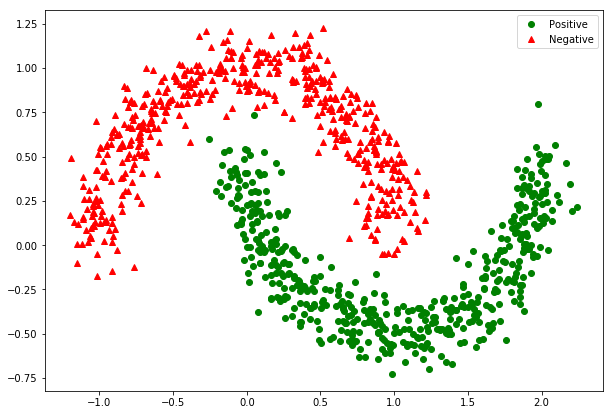

In [61]:
plt.figure(figsize=(10,7))
plt.plot(X_moons[y_moons==1, 0], X_moons[y_moons==1, 1], "go", label="Positive")
plt.plot(X_moons[y_moons==0, 0], X_moons[y_moons==0, 1], "r^", label="Negative")
plt.legend()
plt.show()

In [65]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]
y_moons_column_vector = y_moons.reshape(-1,1)

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_moons_with_bias, y_moons_column_vector,test_size=0.2)

In [68]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

recall that logistic regression probabilities are generated via
\begin{equation}
\mathbf{\hat{p}} = \sigma (\mathbf{X \dot \theta})
\end{equation}
where $\sigma$ is the sigmoid function with the log loss cost function

In [69]:
tf.reset_default_graph()

n_inputs = 2 #X is two dimensional + 1 for bias
X = tf.placeholder(tf.float32, shape=(None, n_inputs+1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = tf.sigmoid(logits)
loss = tf.losses.log_loss(y, y_proba)

Instructions for updating:
Use tf.cast instead.


In [70]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [72]:
init = tf.global_variables_initializer()

n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict=({X: X_batch, y: y_batch}))
        loss_val = loss.eval({X: X_test, y:y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 1.04048
Epoch: 100 	Loss: 0.31258702
Epoch: 200 	Loss: 0.28083515
Epoch: 300 	Loss: 0.27191556
Epoch: 400 	Loss: 0.26865384
Epoch: 500 	Loss: 0.26753926
Epoch: 600 	Loss: 0.2677523
Epoch: 700 	Loss: 0.26791596
Epoch: 800 	Loss: 0.26825628
Epoch: 900 	Loss: 0.26899615


In [73]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

y_pred = (y_proba_val >= 0.5)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

Accuracy:  0.89
Precision:  0.8888888888888888
Recall:  0.8888888888888888


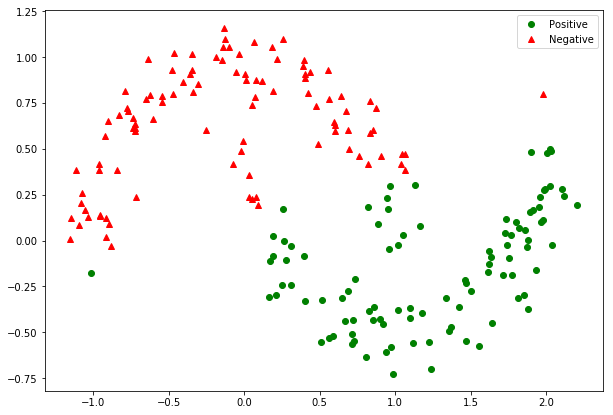

In [74]:
y_pred_idx = y_pred.reshape(-1)
plt.figure(figsize=(10,7))
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Considering we are separating the two moons with a linear model, this is about what we would expect...

Let's make this more sophisticated:
* Add non-linear features for our model linear model to train on
* Define the graph with a logistic_regression() function
* Save checkpoints using a Saver and save the final model at the end of training
* Define the graph such that is looks good in Tensorboard
* Add summaries to visualize the learning curves in Tensorboard

In [85]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=3, include_bias=False)

X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

In [76]:
tf.reset_default_graph()

In [77]:
def logistic_regression(X, y, initializer=None, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_reg"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

In [92]:
# function to get the name of the log directory to save the summaries for Tensorboard
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = os.getcwd() + "/tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}".format(root_logdir, name)

In [93]:
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, X_train_poly.shape[1]), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [94]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = os.getcwd() + "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = os.getcwd() + "/my_logreg_model"

In [97]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # Use checkpoint file if it exists
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
    else:
        start_epoch = 0
        sess.run(init)
    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_poly, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_poly, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
                
    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_poly, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 1.562633
Epoch: 500 	Loss: 0.13959737
Epoch: 1000 	Loss: 0.10150392
Epoch: 1500 	Loss: 0.084360115
Epoch: 2000 	Loss: 0.07364376
Epoch: 2500 	Loss: 0.066437155
Epoch: 3000 	Loss: 0.061112355
Epoch: 3500 	Loss: 0.05657682
Epoch: 4000 	Loss: 0.053950872
Epoch: 4500 	Loss: 0.051413346
Epoch: 5000 	Loss: 0.048829164
Epoch: 5500 	Loss: 0.047206525
Epoch: 6000 	Loss: 0.045231428
Epoch: 6500 	Loss: 0.043936998
Epoch: 7000 	Loss: 0.04234706
Epoch: 7500 	Loss: 0.041140806
Epoch: 8000 	Loss: 0.040145844
Epoch: 8500 	Loss: 0.039439797
Epoch: 9000 	Loss: 0.038432047
Epoch: 9500 	Loss: 0.03780051
Epoch: 10000 	Loss: 0.036879092


In [98]:
y_pred = (y_proba_val >= 0.5)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

Accuracy:  0.99
Precision:  1.0
Recall:  0.9797979797979798


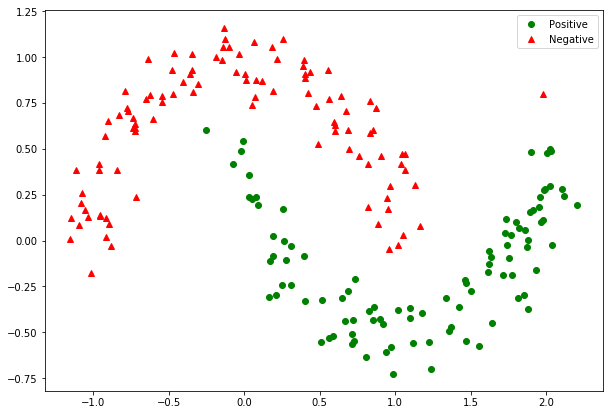

In [99]:
y_pred_idx = y_pred.reshape(-1)
plt.figure(figsize=(10,7))
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Much better with the polynomial features added! Now, looking at the graph on tensorboard with
```
$ tensorboard --logdir=tf_logs
```


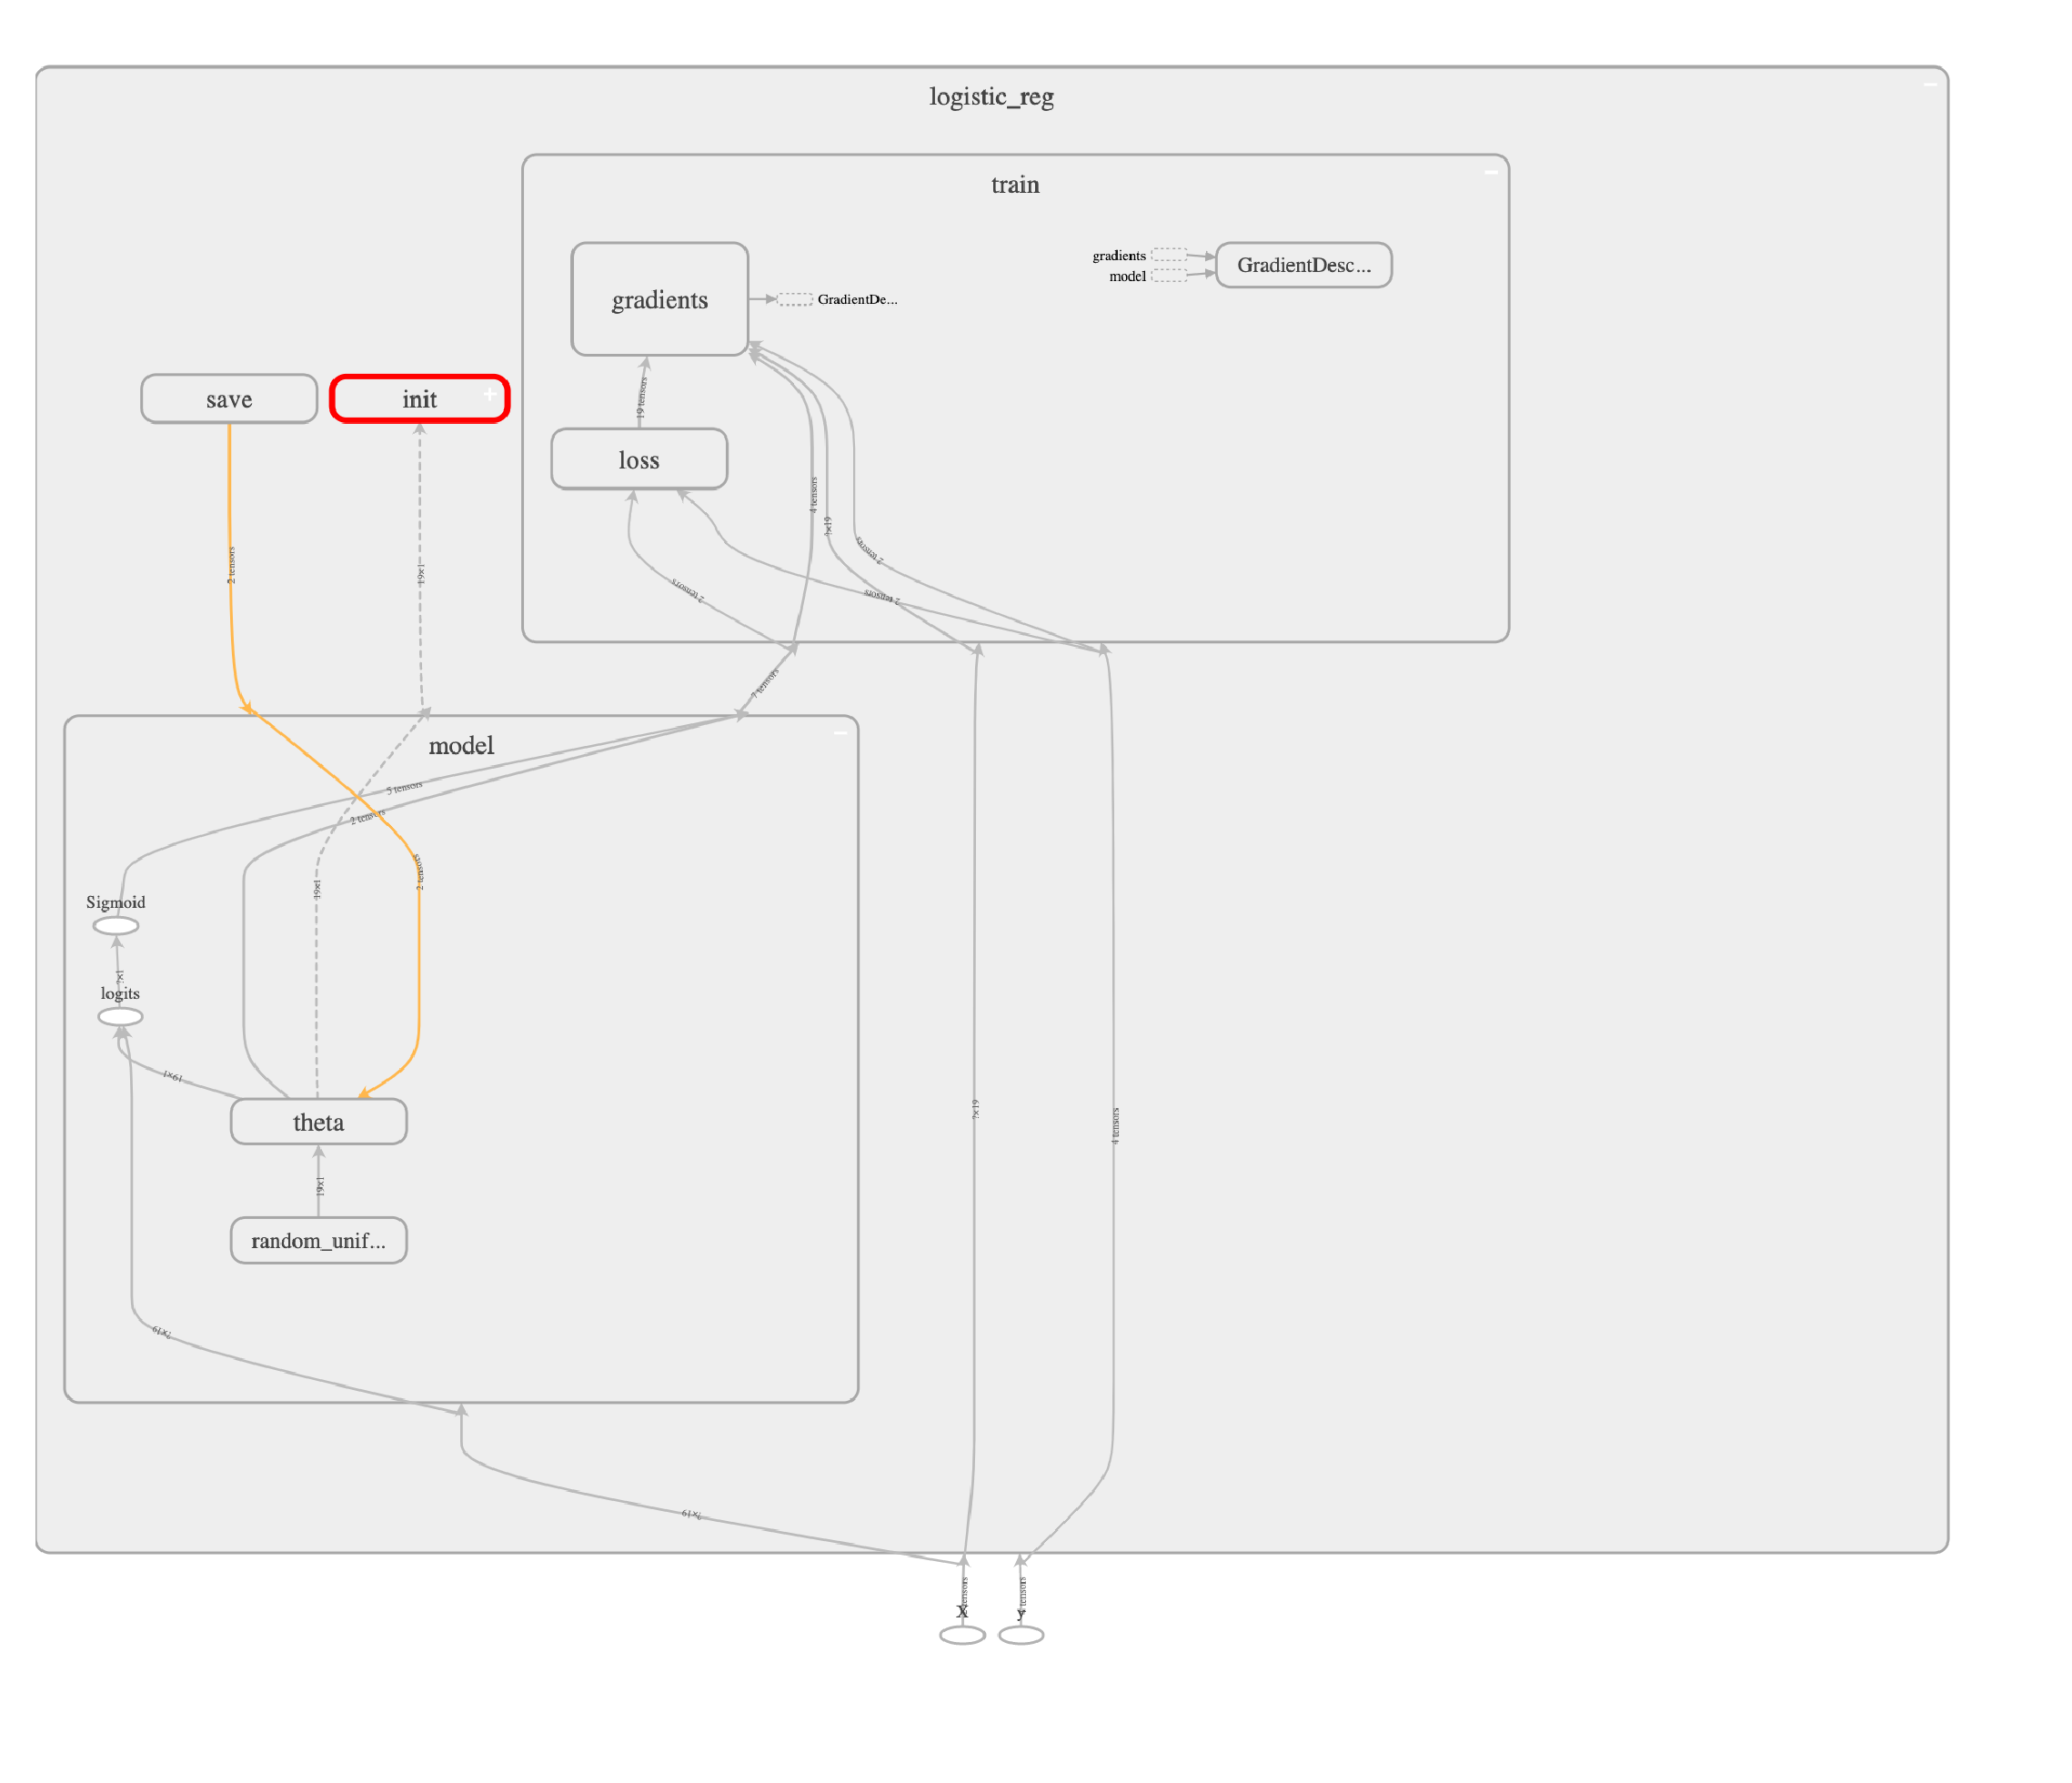

In [104]:
import matplotlib.image as mpimg
plt.figure(figsize=(40,40))
img = mpimg.imread(os.getcwd() + "/images/log_reg_ch9_tensorboard.png")
plt.imshow(img)
plt.axis('off')
plt.show()

## What did we accomplish?

1. Making and managing basic tensorflow graphs
2. Implemented linear regression via batch and mini-batch gradient descent and the normal equation
3. Learned how to save and restore a tensorflow model
4. Implemented logistic regression with batch gradient descent and visualized the graph on TensorBoard